In [1]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)

import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers
from sklearn.cluster import KMeans
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
import math

In [65]:
def plot_imgs(imgs):
    n_imgs = len(imgs)
    square_size = 2  # inches
    n_cols = math.ceil(math.sqrt(n_imgs))
    n_rows = math.ceil(n_imgs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(square_size, square_size),gridspec_kw=dict(wspace=0, hspace=0))
    
    # Flatten axes for easy indexing
    axes = axes.flatten()
    
    for i in range(n_imgs):
        axes[i].imshow(imgs[i])  # Replace with your image array
        axes[i].axis('off')
    
    # Hide any extra axes (if grid is larger than number of images)
    for i in range(n_imgs, len(axes)):
        axes[i].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove spacing between subplots
    plt.show()
    
    return fig

def get_k_imgs(dim_rid1, dataset, k, dim):
    sorted_indices = np.argsort(dim_rid1[:, dim])  # ascending order
    
    topk_indices = sorted_indices[-k:][::-1]  # descending: highest values
    bottomk_indices = sorted_indices[:k] 
    topk_imgs = [dataset[i][0].permute(1,2,0) for i in topk_indices]
    bottomk_imgs = [dataset[i][0].permute(1,2,0) for i in bottomk_indices]
    return topk_imgs, bottomk_imgs

In [3]:
transform = transforms.Compose(
    [      
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
) #       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    
dataset = datasets.ImageFolder(f"{paths["data_path"]}/imagenet", transform=transform)

In [4]:
model_name1 = "resnet50"
model_name2 = "vit_b_16"
mod1_layers = get_relevant_output_layers(model_name1)
mod2_layers = get_relevant_output_layers(model_name2)

In [5]:

target_layer1 = mod1_layers[10]
target_layer2 = mod2_layers[3]

pooling = "maxpool"
n_components_cca = 50
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
feats1 = joblib.load(feats_path1)
PCs1_path = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_pca_model_1000_PCs.pkl"
PCs1 = joblib.load(PCs1_path)
feats_path2 = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_features.pkl"
feats2 = joblib.load(feats_path2)
PCs2_path = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_pca_model_1000_PCs.pkl"
PCs2 = joblib.load(PCs2_path)
cca_path = f"{paths["results_path"]}/cca_{model_name1}_vs_{model_name2}_{pooling}/cca_{model_name1}_vs_{model_name2}_{n_components_cca}_components_pca_{target_layer1}_vs_{target_layer2}.pkl"

weights_dict = joblib.load(cca_path)

In [6]:
dim_rid1 = feats1@PCs1.components_.T
if feats1.shape[1]>1000:
    d1 = dim_rid1 @ weights_dict["W1"]
else:
    d1 = feats1 @ weights_dict["W1"]

In [7]:
dim_rid2 = feats2@PCs2.components_.T
if feats2.shape[1]>1000:
    d2 = dim_rid2 @ weights_dict["W2"]
else:
    d2 = feats2 @ weights_dict["W2"]

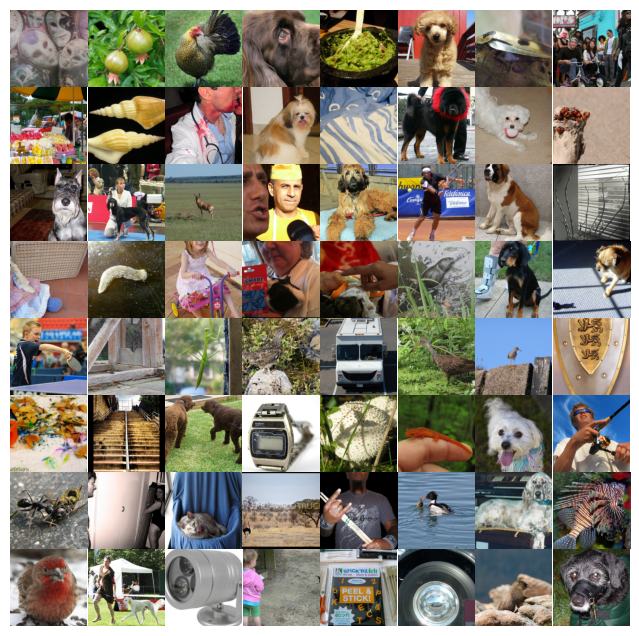

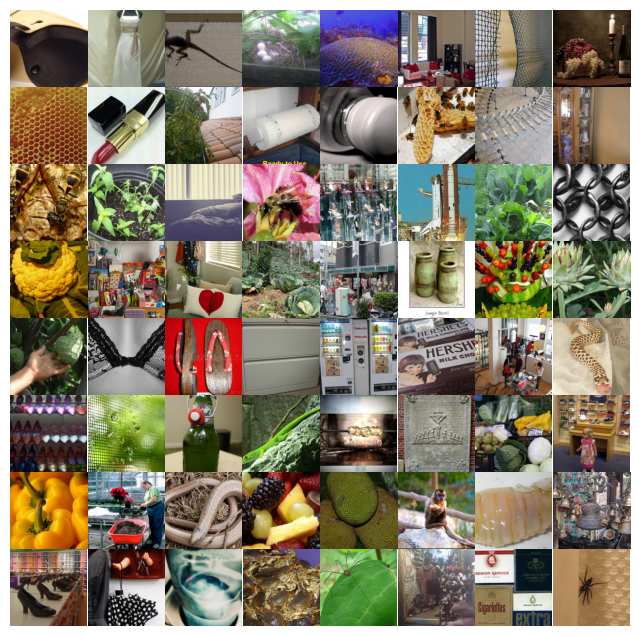

In [9]:
k = 64
dim = 0 
mod2_topk_imgs, mod2_bottomk_imgs = get_k_imgs(dim_rid2, dataset, k, dim)
mod2_topk_imgs_cca, mod2_bottomk_imgs_cca = get_k_imgs(d2, dataset, k, dim)
mod2_top = plot_imgs(mod2_topk_imgs)
mod2_bot = plot_imgs(mod2_bottomk_imgs)

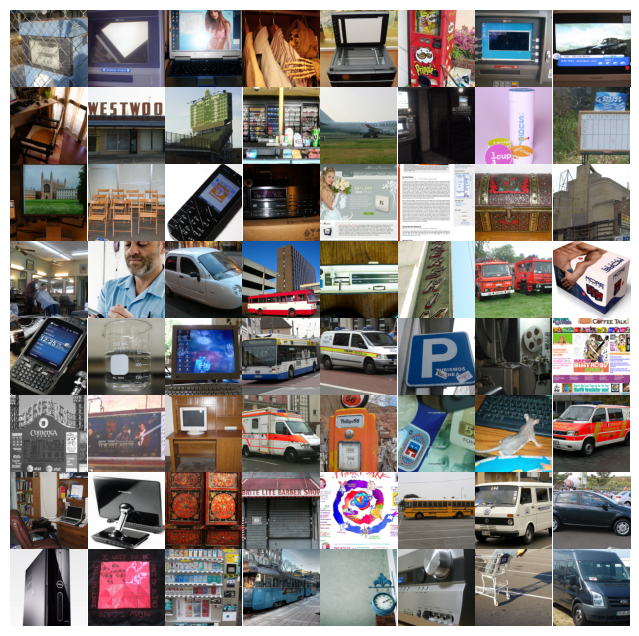

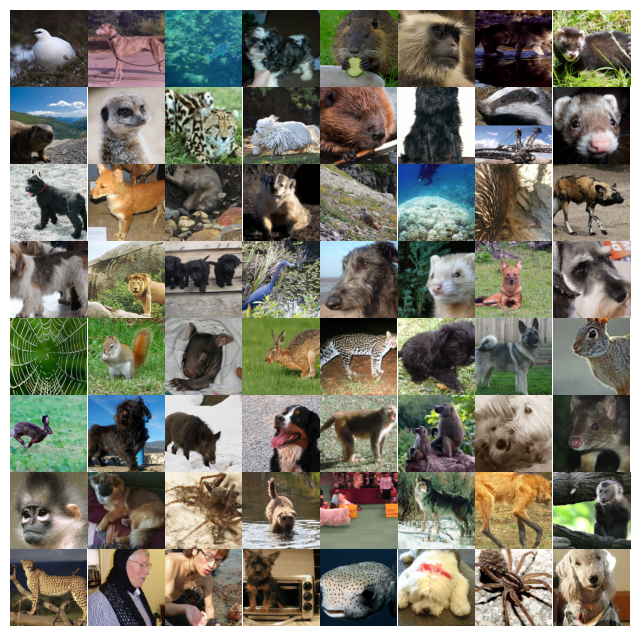

Text(0.5, 0.95, 'resnet50 vs vit_b_16 dim 0')

In [10]:
mod2_cca_top_plot = plot_imgs(mod2_topk_imgs_cca)
mod2_cca_top_plot.suptitle(f"{model_name1} vs {model_name2} dim {dim}", fontsize=16, y=0.95)
mod2_cca_bot_plot = plot_imgs(mod2_bottomk_imgs_cca)
mod2_cca_bot_plot.suptitle(f"{model_name1} vs {model_name2} dim {dim}", fontsize=16, y=0.95)

In [8]:
dim1_sort_idx = np.argsort(d2[:,1]) # in increasing order

In [37]:
#dim1_range = d2[dim1_sort_idx[-1], 1] - d2[dim1_sort_idx[0], 1] # max - min , could have been np.max(d2[:,0]) - np.min(d2[:,0])
#middle_lev1 = d2[dim1_sort_idx[0], 1]+dim1_range/2

print(middle_lev1)

-4.406867233290545


In [130]:
def get_extreme_k(data, dataset, k, dim, extreme):
    sorted_indices = np.argsort(data)  # ascending order
    if extreme == "top":
        topk_indices = sorted_indices[-k:]  
        return topk_indices
    elif extreme == "bottom":
        bottomk_indices = sorted_indices[:k] 
        return bottomk_indices
        
def get_dimension_progression(num_conditions, data, tol, dims, k=10):
    slice_dim, progress_dim = dims
    middle_lev_slice = (np.max(data[:,slice_dim]) + np.min(data[:,slice_dim]))/2
    slice_dim_usable_idx = np.where(np.logical_and(
        data[:, slice_dim] > middle_lev_slice - tol,
        data[:, slice_dim] < middle_lev_slice + tol
    ))[0]
    progress_dim_usable = np.squeeze(data[slice_dim_usable_idx, progress_dim])
    progress_dim_usable_range = np.max(progress_dim_usable) - np.min(progress_dim_usable)
    progress_dim_levels = np.linspace(np.max(progress_dim_usable), np.min(progress_dim_usable), num_conditions)
    print("\nmax :", np.max(progress_dim_usable), "\nmin :", np.min(progress_dim_usable))
    print(f"levels {progress_dim_levels}")
    img_levels_usable = [np.where(np.logical_and(
        progress_dim_usable > progress_dim_levels[lev] - tol,
        progress_dim_usable < progress_dim_levels[lev] + tol
    ))[0] for lev in range(num_conditions)]
    img_levels = [slice_dim_usable_idx[idx_lvl] for idx_lvl in img_levels_usable]
    if len(img_levels[0]) < k:
        print(f"only {len(img_levels[0])} images for the top extreme, getting top {k}")
        extreme = "top"
        img_levels_top_idx = get_extreme_k(progress_dim_usable, dataset, k, 0, extreme)
        img_levels[0] = slice_dim_usable_idx[img_levels_top_idx]
    if len(img_levels[-1]) < k:
        print(f"only {len(img_levels[-1])} images for the bottom extreme, getting bottom {k}")
        extreme = "bottom"
        img_levels_bot_idx = get_extreme_k(progress_dim_usable, dataset, k, 0, extreme)
        img_levels[-1] = slice_dim_usable_idx[img_levels_bot_idx]
    print(len(img_levels[0]), len(img_levels[-1]))
    return img_levels
    
    

In [38]:
num_conditions = 9

middle_lev1 = (np.max(d2[:,1]) + np.min(d2[:,1]))/2
#levels0 = np.linspace(d2[dim0_sort_idx[0], 0], d2[dim0_sort_idx[-1], 0], num_conditions)
#middle_lev0 = levels[len(levels) // 2]

In [59]:
tol = 0.2
dim1_usable_idx = np.where(np.logical_and(
    d2[:, 1] > middle_lev1 - tol,
    d2[:, 1] < middle_lev1 + tol
))[0]

In [28]:
dim0_usable = np.squeeze(d2[dim1_usable_idx, 0])


In [30]:
print(dim0_usable.shape)


(1337,)


In [31]:
dim0_usable_range = np.max(dim0_usable) - np.min(dim0_usable)
dim0_levels = np.linspace(np.max(dim0_usable), np.min(dim0_usable), num_conditions)
print(dim0_levels)

[ 3.20551506  2.76979975  2.33408445  1.89836914  1.46265384  1.02693853
  0.59122322  0.15550792 -0.28020739]


In [95]:
tol = .2
img_levels = [np.where(np.logical_and(
    dim0_usable > dim0_levels[lev] - tol,
    dim0_usable < dim0_levels[lev] + tol
))[0] for lev in range(num_conditions)]


In [119]:
img_lvls = get_dimension_progression(9, d1, .4, (0,2))

1.3131083493929878 -7.227749320015876
[ 1.31310835  0.24550114 -0.82210607 -1.88971328 -2.95732049 -4.02492769
 -5.0925349  -6.16014211 -7.22774932]
2 1
getting top 10
getting bottom 10



max 3.2055150588277077 
min: -0.08643981156713132
levels [ 3.20551506  2.7940207   2.38252634  1.97103198  1.55953762  1.14804326
  0.73654891  0.32505455 -0.08643981]
only 8 images for the top extreme, getting top 10
only 4 images for the top extreme, getting bottom 10
10 10
4


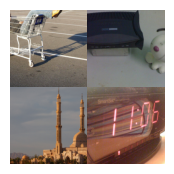

4


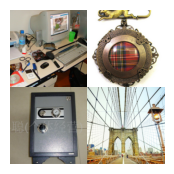

4


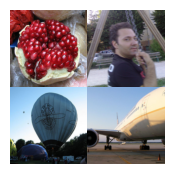

4


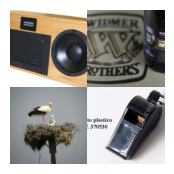

4


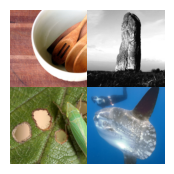

4


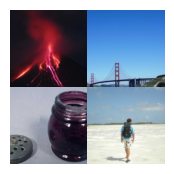

4


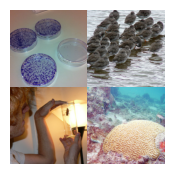

4


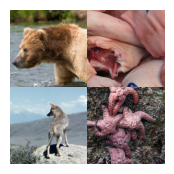

4


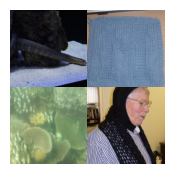

In [131]:
img_lvls = get_dimension_progression(9, d2, .15, (1,0))


for i in range(num_conditions):
    curr_idx = img_lvls[i]
    rand2 =  np.random.choice(len(curr_idx), size=min(curr_idx.shape[0],4), replace=False)
    imgs = [dataset[int(idx)][0].permute(1, 2, 0) for idx in curr_idx[rand2]]
    print(len(imgs))
    #plot_imgs(dataset[curr_idx[:2]][0].permute(1,2,0))
    plot_imgs(imgs)

In [115]:
#print(np.max(dim1_usable) - np.min(dim1_usable))
#for i in range(50):
#    print(f"dim {i}", np.var(d2[:,i]))